[nltk_data] Downloading package punkt to
[nltk_data]     /Users/parthbatwara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/parthbatwara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/parthbatwara/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Number of words removed (appearing in ≥80% of summaries): 23
Silhouette Score: 0.288


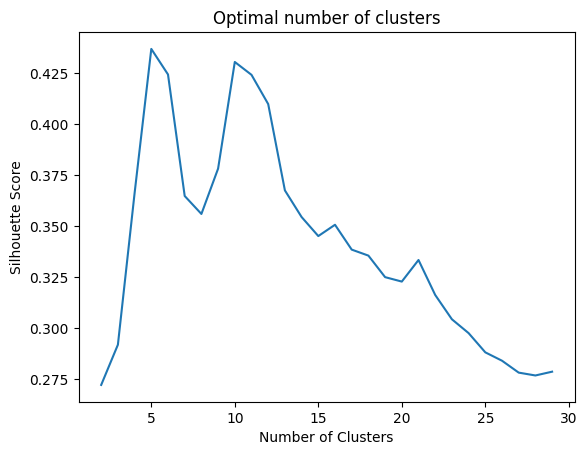

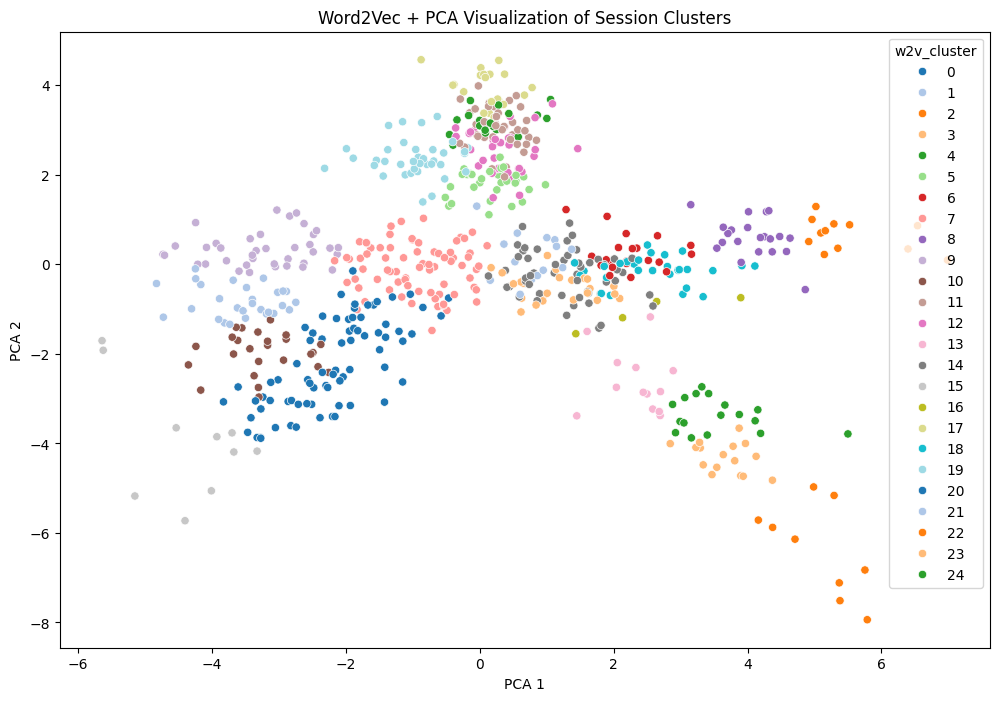


Cluster 0 (37 summaries):
[  7  10  30  43  62 102 134 162 207 251 275 302 306 316 321 334 342 379
 390 398 405 419 422 458 477 486 500 501 519 527 550 569 581 600 604 615
 623]

Cluster 1 (14 summaries):
[ 19 110 121 131 145 257 269 406 416 439 464 564 594 601]

Cluster 2 (12 summaries):
[  2  54  63  70  85 143 411 445 472 487 567 571]

Cluster 3 (16 summaries):
[172 191 217 278 357 364 385 403 404 420 446 454 481 488 621 660]

Cluster 4 (18 summaries):
[ 11 158 174 256 270 279 298 303 355 383 474 484 491 535 562 580 592 641]

Cluster 5 (31 summaries):
[  5  16  21  27  28  88  90 111 116 132 133 178 200 284 293 345 371 387
 393 424 425 427 432 451 473 502 514 539 605 614 617]

Cluster 6 (21 summaries):
[  8  49  93 130 135 203 264 283 320 455 467 476 545 566 593 597 608 630
 631 647 648]

Cluster 7 (75 summaries):
[  1  31  35  48  55  60  73  87  96 107 108 117 136 142 144 148 164 170
 185 190 195 204 216 224 233 235 244 247 248 261 262 276 281 300 309 311
 312 325 327 329 340 344

/var/folders/q1/r9lsqt2n4dz2fbpxq3wwh7m80000gn/T/ipykernel_17663/109600681.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='tab20')


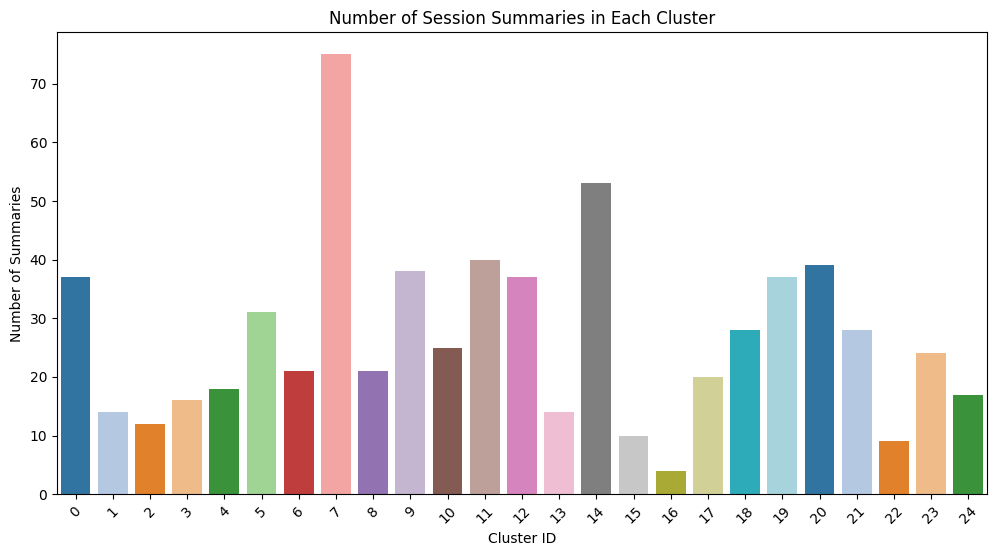


Summaries in Cluster 0 (Total: 37) — Sorted by Similarity:
Serial No: 251.0, Similarity: 0.9975
Serial No: 30.0, Similarity: 0.9968
Serial No: 7.0, Similarity: 0.9961
Serial No: 600.0, Similarity: 0.9957
Serial No: 486.0, Similarity: 0.9952
Serial No: 302.0, Similarity: 0.9952
Serial No: 379.0, Similarity: 0.9951
Serial No: 342.0, Similarity: 0.9950
Serial No: 10.0, Similarity: 0.9943
Serial No: 550.0, Similarity: 0.9938
Serial No: 405.0, Similarity: 0.9930
Serial No: 500.0, Similarity: 0.9929
Serial No: 419.0, Similarity: 0.9927
Serial No: 581.0, Similarity: 0.9925
Serial No: 390.0, Similarity: 0.9924
Serial No: 519.0, Similarity: 0.9918
Serial No: 477.0, Similarity: 0.9907
Serial No: 43.0, Similarity: 0.9903
Serial No: 422.0, Similarity: 0.9896
Serial No: 615.0, Similarity: 0.9892
Serial No: 458.0, Similarity: 0.9891
Serial No: 527.0, Similarity: 0.9877
Serial No: 604.0, Similarity: 0.9869
Serial No: 398.0, Similarity: 0.9848
Serial No: 334.0, Similarity: 0.9823
Serial No: 62.0, Sim

In [3]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.metrics import silhouette_score
from collections import defaultdict
from collections import Counter
import joblib

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# ------------------------
# 1. Load Data
# ------------------------
df = pd.read_excel("../Session-Summary-for-E6-project.xlsx")
df = df.dropna(subset=['Session_Summary'])

# ------------------------
# 2. Preprocessing
# ------------------------
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w.isalpha() and w not in stop_words]
    return tokens

df['tokens'] = df['Session_Summary'].apply(clean_text)

# ------------------------
# 3. Remove high-frequency words (appearing in >=80% of summaries)
# ------------------------
# Count in how many summaries each word appears
summary_counts = Counter()

for tokens in df['tokens']:
    unique_tokens = set(tokens)
    summary_counts.update(unique_tokens)

# Threshold: words appearing in >=80% of summaries
threshold = 0.3 * len(df)
common_words = set([word for word, count in summary_counts.items() if count >= threshold])

print(f"\nNumber of words removed (appearing in ≥80% of summaries): {len(common_words)}")

# Remove those words from tokens
df['filtered_tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in common_words])

# ------------------------
# 4. Train Word2Vec Model (CBOW)
# ------------------------
w2v_model = Word2Vec(sentences=df['filtered_tokens'], vector_size=300, window=300, min_count=2, sg=0, workers=4, seed=42)

# ------------------------
# 5. Average Word Vectors for Each Summary
# ------------------------
def get_avg_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

df['vector'] = df['filtered_tokens'].apply(lambda x: get_avg_vector(x, w2v_model))
X_w2v = np.vstack(df['vector'].values)

# ------------------------
# 6. KMeans Clustering (25 sessions)
# ------------------------
kmeans = KMeans(n_clusters=25, random_state=42)
df['w2v_cluster'] = kmeans.fit_predict(X_w2v)

# Silhouette Score
sil_score = silhouette_score(X_w2v, df['w2v_cluster'])
print(f"Silhouette Score: {sil_score:.3f}")

# Silhouette scores for various K
scores = []
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_w2v)
    score = silhouette_score(X_w2v, labels)
    scores.append(score)

plt.plot(range(2, 30), scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Optimal number of clusters")
plt.show()

# ------------------------
# 7. Visualize using PCA
# ------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_w2v)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['w2v_cluster'], palette='tab20', legend='full')
plt.title("Word2Vec + PCA Visualization of Session Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

# ------------------------
# 8. Group Serial Numbers by Cluster
# ------------------------
cluster_groups = defaultdict(list)

for idx, row in df.iterrows():
    cluster_id = row['w2v_cluster']
    serial_no = row['SerialNo']
    cluster_groups[cluster_id].append(serial_no)

# Convert to list of arrays
session_clusters = [np.array(cluster_groups[i]) for i in range(25)]

# Display grouped arrays
for i, cluster in enumerate(session_clusters):
    print(f"\nCluster {i} ({len(cluster)} summaries):")
    print(cluster)

# ------------------------
# 9. Plot frequency of sessions in each cluster
# ------------------------
cluster_counts = df['w2v_cluster'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='tab20')
plt.title("Number of Session Summaries in Each Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Summaries")
plt.xticks(rotation=45)
plt.show()

# ------------------------
# 10. Compute Global Word2Vec Vector for Each Cluster
# ------------------------

# Compute average vector for each cluster
global_cluster_vectors = {
    cluster_id: np.mean(X_w2v[df['w2v_cluster'] == cluster_id], axis=0)
    for cluster_id in range(25)
}

# Dictionary to hold global vectors for each cluster
from scipy.spatial.distance import cosine

# Dictionary to store ordered summaries by similarity for each cluster
ordered_summaries_by_similarity = {}

for cluster_id in range(25):
    # Get global vector for the cluster
    global_vector = global_cluster_vectors[cluster_id]
    
    # Get all summaries in this cluster
    cluster_df = df[df['w2v_cluster'] == cluster_id][['SerialNo', 'vector']]
    
    # Compute cosine similarity between each summary's vector and the global vector
    cluster_df['similarity'] = cluster_df['vector'].apply(lambda vec: 1 - cosine(vec, global_vector) if np.linalg.norm(vec) != 0 and np.linalg.norm(global_vector) != 0 else 0)
    
    # Sort by decreasing similarity
    cluster_df = cluster_df.sort_values(by='similarity', ascending=False)
    
    # Store ordered SerialNos and similarity for this cluster
    ordered_summaries_by_similarity[cluster_id] = cluster_df[['SerialNo', 'similarity']].values.tolist()
    
    # Print all summaries for this cluster
    print(f"\nSummaries in Cluster {cluster_id} (Total: {len(cluster_df)}) — Sorted by Similarity:")
    for serial, sim in ordered_summaries_by_similarity[cluster_id]:
        print(f"Serial No: {serial}, Similarity: {sim:.4f}")


In [4]:
from scipy.spatial.distance import cosine

# Cluster to work with
target_cluster_id = 0

# Get summaries in Cluster 0
cluster_df = df[df['w2v_cluster'] == target_cluster_id][['SerialNo', 'filtered_tokens', 'vector']]

for idx, row in cluster_df.iterrows():
    serial_no = row['SerialNo']
    tokens = row['filtered_tokens']
    summary_vector = row['vector']
    
    word_similarities = []
    
    # Use set(tokens) to avoid duplicate words
    for word in set(tokens):
        if word in w2v_model.wv:
            word_vector = w2v_model.wv[word]
            similarity = 1 - cosine(word_vector, summary_vector) if np.linalg.norm(word_vector) != 0 and np.linalg.norm(summary_vector) != 0 else 0
            word_similarities.append((word, similarity))
    
    # Sort words by decreasing similarity
    word_similarities.sort(key=lambda x: x[1], reverse=True)
    
    # Print results for this summary
    print(f"\nSummary Serial No: {serial_no} — Top words by similarity to its own averaged vector:")
    for word, sim in word_similarities:
        print(f"{word}: {sim:.4f}")



Summary Serial No: 7 — Top words by similarity to its own averaged vector:
size: 0.9869
say: 0.9745
whole: 0.9695
learned: 0.9641
parameter: 0.9273
thing: 0.9210
pdf: 0.9193
small: 0.9092
measure: 0.8921
population: 0.8888
limit: 0.8834
central: 0.8810
statistical: 0.8755
theorem: 0.8754
confidence: 0.8711
make: 0.8653
assuming: 0.8599
tried: 0.8514
less: 0.8456
interval: 0.8434
plotted: 0.8408
estimate: 0.8370
term: 0.8342
calculate: 0.8168
extra: 0.7917
key: 0.7890
introduction: 0.7849
company: 0.7802
hour: 0.7707
better: 0.7679
worked: 0.7673
represented: 0.7498
real: 0.7469
manager: 0.7465
explained: 0.7335
started: 0.7264
decision: 0.7258
test: 0.7161
u: 0.6956
sir: 0.6637
wrapped: 0.6633
touched: 0.6265
important: 0.5964
variance: 0.5936
explain: 0.5676
useful: 0.5520
observation: 0.5477
talking: 0.4935
result: 0.4931
two: 0.4813
based: 0.4787
example: 0.4434
significantly: 0.4305
probability: 0.3854
work: 0.3495
function: 0.2708
help: 0.2516
density: 0.1915
confidently: 0.1856


In [5]:
from collections import Counter
from scipy.spatial.distance import cosine

# Number of clusters
num_clusters = 25

# Initialize 2D list to hold top 20 keywords per cluster
cluster_keywords = []

# Loop through all clusters
for cluster_id in range(num_clusters):
    # Get summaries in this cluster
    cluster_df = df[df['w2v_cluster'] == cluster_id][['SerialNo', 'filtered_tokens', 'vector']]

    # List to collect all keywords in this cluster
    all_keywords = []

    # Process each summary in the cluster
    for idx, row in cluster_df.iterrows():
        tokens = row['filtered_tokens']
        summary_vector = row['vector']

        word_similarities = []

        # Use set(tokens) to avoid duplicate words within a summary
        for word in set(tokens):
            if word in w2v_model.wv:
                word_vector = w2v_model.wv[word]
                similarity = 1 - cosine(word_vector, summary_vector) if np.linalg.norm(word_vector) != 0 and np.linalg.norm(summary_vector) != 0 else 0
                word_similarities.append((word, similarity))

        # Sort words by decreasing similarity
        word_similarities.sort(key=lambda x: x[1], reverse=True)

        # Add words from this summary to the cluster's keyword list
        summary_keywords = [word for word, sim in word_similarities]
        all_keywords.extend(summary_keywords)

    # Count frequency of each word in this cluster
    keyword_counts = Counter(all_keywords)

    # Get top 20 most frequent keywords
    top_20_keywords = [word for word, count in keyword_counts.most_common(20)]

    # Append to the 2D list
    cluster_keywords.append(top_20_keywords)

# Print the 2D list
for cluster_id, keywords in enumerate(cluster_keywords):
    print(f"\nTop 20 keywords for Cluster {cluster_id}:")
    print(keywords)



Top 20 keywords for Cluster 0:
['interval', 'confidence', 'statistically', 'population', 'independent', 'parameter', 'zero', 'coefficient', 'term', 'mlr', 'learned', 'started', 'example', 'significant', 'statistical', 'function', 'lie', 'u', 'variance', 'simple']

Top 20 keywords for Cluster 1:
['accuracy', 'matrix', 'function', 'logistic', 'precision', 'recall', 'confusion', 'false', 'detected', 'weight', 'number', 'metric', 'positive', 'event', 'many', 'expectation', 'negative', 'descent', 'gradient', 'form']

Top 20 keywords for Cluster 2:
['binary', 'encoding', 'target', 'frequency', 'label', 'convert', 'category', 'categorical', 'technique', 'problem', 'dimensionality', 'column', 'integer', 'numerical', 'learning', 'text', 'vectorization', 'assigns', 'multiclass', 'machine']

Top 20 keywords for Cluster 3:
['ratio', 'measurement', 'nominal', 'ordinal', 'learning', 'interval', 'supervised', 'unsupervised', 'level', 'label', 'discrete', 'continuous', 'classification', 'x', 'gender'

In [6]:
# Save after building
joblib.dump(df, "df_with_vectors.pkl")
joblib.dump(w2v_model, "w2v_model.pkl")
joblib.dump(global_cluster_vectors, "global_cluster_vectors.pkl")

['global_cluster_vectors.pkl']